<a href="https://colab.research.google.com/github/Nikita-Gz/ArGen2/blob/main/ArGen2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental notebook, showing how to achieve interesting effects with untrained neural networks, creative algebra, and mathematical visual effects

In [1]:
!pip install ffmpeg-python

In [2]:
import numpy as np
from typing import Any, Callable

In [3]:
def create_plane(resolution: tuple[int, int], scale: float) -> np.array:
    """ Creates a coordinate plane of specified resolution, with the last
    dimension of length 2 being the coordinates """
    x = resolution[0]
    y = resolution[1]
    smallest_side = min(x, y)

    # the coordinate values are scaled so that the smallest axist matches the scale
    x_range = np.linspace(-scale, scale, x) * x / smallest_side
    y_range = -np.linspace(-scale, scale, y) * y / smallest_side

    x_grid, y_grid = np.meshgrid(x_range, y_range)
    coordinate_plane = np.dstack((x_grid, y_grid))
    return coordinate_plane

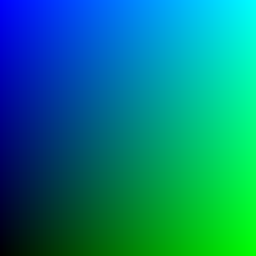

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

def matrix_to_image(matrix, min_val=-1, max_val=1, resolution=(256, 256)) -> Image:
    normalized_matrix = np.clip(matrix, min_val, max_val)
    normalized_matrix = (normalized_matrix - min_val) / (max_val - min_val)

    # Convert to image to BW if it has 1 axis only, or BG and BR if 2 axises,
    # or full RGB if 3 axises
    color_matrix = np.zeros((*matrix.shape[:2], 3))
    match matrix.shape[2]:
        case 1:
            color_matrix[:, :, 0] = normalized_matrix[:, :, 0]  # R
            color_matrix[:, :, 1] = normalized_matrix[:, :, 0]  # G
            color_matrix[:, :, 2] = normalized_matrix[:, :, 0]  # B
        case 2:
            color_matrix[:, :, 0] = 0  # R
            color_matrix[:, :, 1] = normalized_matrix[:, :, 0]  # G
            color_matrix[:, :, 2] = normalized_matrix[:, :, 1]  # B
        case 3:
            color_matrix = normalized_matrix
        case _:
            raise ValueError(f"Invalid matrix shape: {normalized_matrix.shape}")

    gradient_uint8 = (color_matrix * 255).astype(np.uint8)

    img = Image.fromarray(gradient_uint8)
    return img


plane = create_plane((256, 256), 1)
matrix_to_image(plane)

# Effects matrices

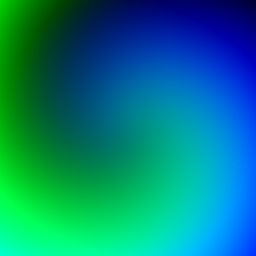

In [5]:
def rotate_around_center(coordinate_plane, center=(0, 0), scale:float=1, phase:float=0) -> np.array:
    # Extract x and y coordinates from the coordinate plane
    x_coords, y_coords = coordinate_plane[:, :, 0], coordinate_plane[:, :, 1]

    # Calculate the distance from each point to the center
    distance_to_center = np.sqrt((x_coords - center[0])**2 + (y_coords - center[1])**2)

    # Calculate angle of rotation for each point relative to the center
    angle = np.arctan2(y_coords - center[1], x_coords - center[0])

    # Apply rotation based on distance from center
    rotated_x = center[0] + (x_coords - center[0]) * np.cos(scale * distance_to_center + phase) - (y_coords - center[1]) * np.sin(scale * distance_to_center + phase)
    rotated_y = center[1] + (x_coords - center[0]) * np.sin(scale * distance_to_center + phase) + (y_coords - center[1]) * np.cos(scale * distance_to_center + phase)

    return np.dstack((rotated_x, rotated_y))

matrix_to_image(rotate_around_center(create_plane((256, 256), 1), scale=2))

<ipython-input-6-02f5fcf0e3be>:16: RuntimeWarning: invalid value encountered in divide
  coordinate_plane_unit_vectors = coordinate_plane / np.linalg.norm(coordinate_plane, axis=-1, keepdims=True)


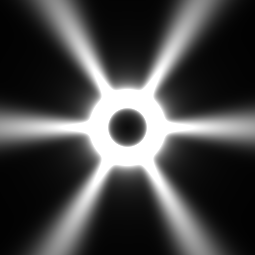

In [6]:
def generate_asterisk_pattern(
        coordinate_plane,
        center=(0, 0),
        num_rays=8,
        ray_width=0.1,
        ray_falloff=0.5,
        center_width=0.2,
        center_outer_ring_falloff=100,
        center_inner_ring_falloff=500):
    """Creates an effect i am experimenting on currently, which resemples the "*"
    sign, with rays stratching from the centre. Except the centre is actually
    a ring"""
    initial_distances = np.linalg.norm(coordinate_plane - center, axis=-1, keepdims=True)

    # "stretches" the coordinate plane to create a ring around the centre, filling it with NaN instead
    coordinate_plane_unit_vectors = coordinate_plane / np.linalg.norm(coordinate_plane, axis=-1, keepdims=True)
    coordinate_plane = np.where(
        initial_distances < center_width,
        np.nan,
        coordinate_plane - coordinate_plane_unit_vectors * center_width)
    x_coords, y_coords = coordinate_plane[:, :, 0], coordinate_plane[:, :, 1]
    altered_distance_to_center = np.linalg.norm(coordinate_plane - center, axis=-1)

    asterisk_pattern = np.zeros_like(altered_distance_to_center)
    angle = np.arctan2(y_coords - center[1], x_coords - center[0])

    # Creates rays based on angle
    for i in range(num_rays):
        ray_angle = i * 2 * np.pi / num_rays
        angle_diff = np.abs(angle - ray_angle)

        # Ensures the angle difference is between 0 and pi
        angle_diff = np.minimum(angle_diff, 2*np.pi - angle_diff)

        # Applies intensity based on angle difference
        asterisk_pattern += np.exp(-angle_diff**2 / (2 * ray_width**2)) / (1 + (altered_distance_to_center**2) * ray_falloff)

    # fills the outer part of the central ring
    center_outer_ring = (1 / altered_distance_to_center**2) / center_outer_ring_falloff
    asterisk_pattern += center_outer_ring

    # fills the inner part of the central ring
    center_inner_ring = np.where(
        initial_distances[:, :, 0] < center_width,
        (1 / (center_width - initial_distances[:, :, 0])**2) / (center_inner_ring_falloff),
        0)
    asterisk_pattern[np.isnan(altered_distance_to_center)] = 0
    asterisk_pattern += center_inner_ring

    return np.expand_dims(asterisk_pattern, axis=-1)

plane = create_plane((255, 255), 1)
astr = generate_asterisk_pattern(plane, num_rays=6, center_width=0.2, ray_falloff=1)
matrix_to_image(astr, 0, 1)

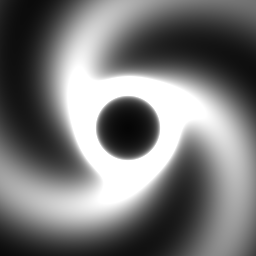

In [7]:
matrix_to_image(
    generate_asterisk_pattern(
        rotate_around_center(
            create_plane((256, 256), 1),
            scale=1.8,
            phase=np.pi / 4),
        num_rays=3,
        ray_width=0.4,
        ray_falloff=1,
        center_width=0.3),
    min_val=0)

# Using random neural networks for colors

In [8]:
import keras
import tensorflow as tf

class SplitActivation(keras.layers.Layer):
    '''
    Custom keras layer that the splits last dimension and passes it through
    different activation functions. The layer is split equally if possible,
    unless split_config is specified
    '''

    def __init__(self, activations, split_config=None, split_dim=-1, **kwargs):
        self._split_dim = split_dim
        self._activations = activations
        self._activations_amount = len(self._activations)
        self._is_config_a_list = isinstance(split_config, list)
        self._split_config = None

        # assert that split_config size matches with activations amount
        if self._is_config_a_list:
            assert len(split_config) == self._activations_amount, (
                'length of activation sizes list ({}) does not match length of '
                'activations list ({})'
                .format(len(split_config), self._activations_amount))
            self._split_config = split_config
        else:
            self._split_config = self._activations_amount

        super(SplitActivation, self).__init__(**kwargs)

    def build(self, input_shape):
        split_dim_size = input_shape[self._split_dim]

        if self._is_config_a_list:
            assert sum(self._split_config) == split_dim_size, (
            'sum of split sizes ({}) does not match the split dimension size ({})'
            .format(sum(self._split_config), split_dim_size))
        else:
            assert (split_dim_size % self._activations_amount) == 0, (
            'last dimension (size {}) cannot be evenly split across '
            'activations (size {})'
            .format(split_dim_size, self._activations_amount))

        super(SplitActivation, self).build(input_shape)


    def call(self, x):
        split_input = tf.split(x, self._split_config, axis=self._split_dim)

        x = tf.concat([activation(input_slice) for input_slice, activation
                        in zip(split_input, self._activations)],
                        axis=self._split_dim)
        return x


In [9]:
def process_array_in_parts(array, processing_function, divide_by_n_parts=8):
    """
    processing input in parts is useful in case the operation uses a lot of memory
    """
    blocks = np.array_split(array, divide_by_n_parts, axis=0)
    outputs = []
    for i, block in enumerate(blocks):
        print("processing block " + str(i+1) + " out of " + str(len(blocks)))
        result = processing_function(block)
        outputs.append(result)

    final_result = np.concatenate(outputs)
    return final_result

In [169]:
from matplotlib.colors import hsv_to_rgb

def postprocessing_effect(colors: np.array) -> np.array:
    """
    Creates an interesting purple effect with sharp contours.
    "colors" is an HSV (..., 3) array.
    """

    original_colors_matrix = np.copy(colors)

    colors[..., 0] = 0.8
    colors[..., 1] = 0.5 + original_colors_matrix[..., 1] * 0.5
    colors[..., 2] = original_colors_matrix[..., 2] **3 + original_colors_matrix[..., 0] **3

    return hsv_to_rgb(colors)

In [197]:
# This network structure creates my favourite pattern by far
staircase_generator = keras.Sequential([
    keras.layers.Dense(16,
                        bias_initializer=keras.initializers.RandomNormal(0, 0.5)),
    SplitActivation([tf.nn.relu, tf.math.sin]),
    keras.layers.Dense(16,
                        bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
                        #bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
    SplitActivation([tf.nn.relu, tf.math.ceil]),
    keras.layers.Dense(16,
                        kernel_initializer=keras.initializers.RandomNormal(0, 0.1),
                        bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
    SplitActivation([tf.nn.relu, tf.math.sin]),

    keras.layers.Dense(3,
                        activation='tanh'),
])

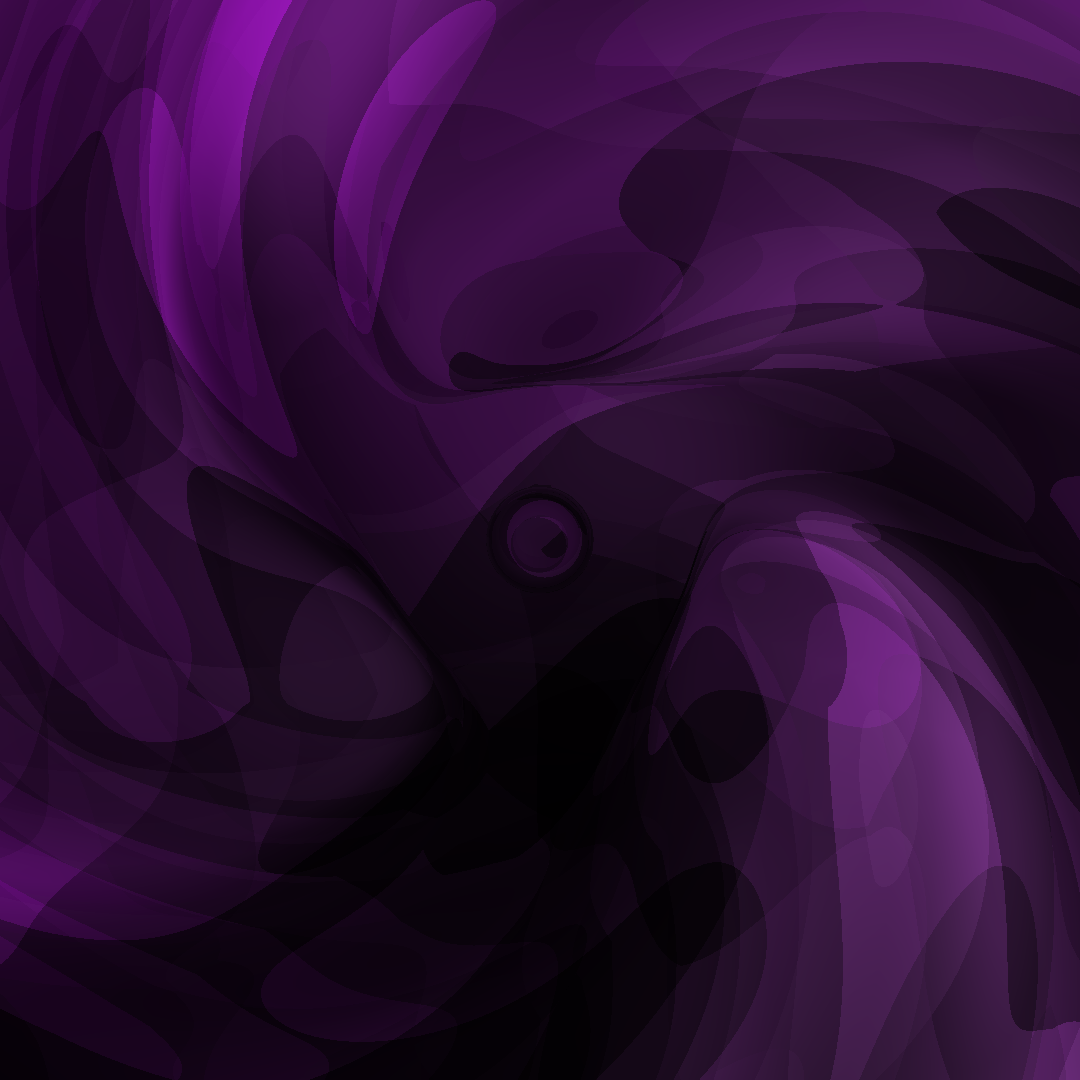

In [198]:
def generate_input_matrix(
        resolution: tuple[int, int],
        coordinates_scale: float,
        asterisk_rotation: float,
        coordinates_rotation: float,
        oscilator_progress: float,
        oscilator_scale: float) -> np.array:
    """
    Creates an effect based on the coordinate plane and the asterisk pattern
    rotating at different periods.
    Also adds two oscilating image-wide values
    """
    image_coordinates_plane = rotate_around_center(
        create_plane(resolution, coordinates_scale),
        scale=0.1,
        phase=coordinates_rotation)

    asterisk_coordinates_plane = rotate_around_center(
        create_plane(resolution, coordinates_scale),
        scale=0.1,
        phase=asterisk_rotation)
    asterisk_pattern = generate_asterisk_pattern(
        asterisk_coordinates_plane,
        num_rays=3,
        ray_width=0.5,
        ray_falloff=0.001,
        center_width=2,
        center_inner_ring_falloff=1,
        center_outer_ring_falloff=2)

    # makes the effect more sharp and noticeable
    asterisk_pattern = (np.clip(asterisk_pattern, 0, 1) ** 3) * 10

    # display(matrix_to_image(asterisk_pattern, min_val=0, max_val=1))

    ones = np.ones_like(asterisk_pattern)
    oscilator1 = np.sin(oscilator_progress) * oscilator_scale * ones
    oscilator2 = np.cos(oscilator_progress) * oscilator_scale * ones

    input_matrix = np.concatenate([
        image_coordinates_plane,
        asterisk_pattern,
        oscilator1,
        oscilator2], axis=-1)
    input_matrix = input_matrix[np.newaxis, ...]
    return input_matrix

input_matrix = generate_input_matrix(
    resolution=(1080, 1080),
    coordinates_scale=10,
    asterisk_rotation=20,
    coordinates_rotation=20,
    oscilator_progress=0,
    oscilator_scale=2)
staircase = (staircase_generator(input_matrix).numpy()[0] + 1) / 2
matrix_to_image(postprocessing_effect(staircase), min_val=0, max_val=1)

# Video generation code

In [184]:
from dataclasses import dataclass


@dataclass
class Keyframe:
    time: float
    value: Any
    interpolation: Callable | None = None


def linear_interpolation(start_keyframe: Keyframe, end_keyframe: Keyframe, time: float) -> float:
    delta_t = end_keyframe.time - start_keyframe.time
    if delta_t == 0:
        return start_keyframe.value

    keyframe_progress = (time - start_keyframe.time) / delta_t
    return start_keyframe.value * (1 - keyframe_progress) + end_keyframe.value * keyframe_progress


class AnimationParameter:
    """Represents parameters in the animation, allowing for interpolation
    between the keyframes as time goes on. If the interpolation function is not
    provided for the keyframe, does linear interpolation by default"""
    def __init__(
            self,
            keyframes: list[Keyframe],
            default_interpolation: Callable = linear_interpolation):
        self._keyframes = sorted(keyframes, key=lambda kf: kf.time)
        self.default_interpolation = default_interpolation


    def __call__(self, time: float) -> Any:
        if len(self._keyframes) == 1:
            return self._keyframes[0].value

        # Finds the keyframes surrounding the given time, assumes they're sorted
        # Todo: maybe implement it without loop, as a challenge?
        prev_keyframe = None
        next_keyframe = None
        for keyframe in self._keyframes:
            if keyframe.time <= time:
                prev_keyframe = keyframe
            if keyframe.time >= time:
                next_keyframe = keyframe
            if prev_keyframe is not None and next_keyframe is not None:
                break
        if prev_keyframe is None:
            return self._keyframes[0].value
        if next_keyframe is None:
            return self._keyframes[-1].value

        interpolation_func = prev_keyframe.interpolation or self.default_interpolation
        return interpolation_func(prev_keyframe, next_keyframe, time)

In [185]:
import ffmpeg

def get_video_writer(resolution: tuple[int, int], fps: int, crf=15):
    writer = (
        ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='rgb24', s=f'{resolution[0]}x{resolution[1]}', r=fps)
            .output('animation.mp4', pix_fmt='yuv420p', crf=crf, vcodec='h264')
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )
    return writer

Creating frame 1 out of 600


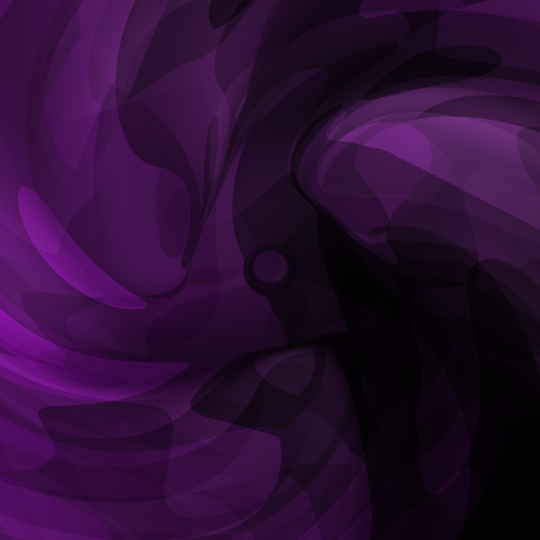

Created frame 1 out of 600
Creating frame 2 out of 600
Created frame 2 out of 600
Creating frame 3 out of 600
Created frame 3 out of 600
Creating frame 4 out of 600
Created frame 4 out of 600
Creating frame 5 out of 600
Created frame 5 out of 600
Creating frame 6 out of 600
Created frame 6 out of 600
Creating frame 7 out of 600
Created frame 7 out of 600
Creating frame 8 out of 600


In [ ]:
frames_in_video = 600
fps = 60
video_target_resolution = (1080, 1080)
video_generation_resolution = (video_target_resolution[0] * 2, video_target_resolution[1] * 2)
video_preview_resolution = (video_target_resolution[0] // 2, video_target_resolution[1] // 2)
coordinate_scale = 10
show_preview_every_n_frames = 100

coordinates_rotation_phase = AnimationParameter([Keyframe(0, 0), Keyframe(1, -np.pi*2)])
asterisk_rotation_phase = AnimationParameter([Keyframe(0, 0), Keyframe(1, np.pi*2)])
oscilator_progress = AnimationParameter([Keyframe(0, 0), Keyframe(1, np.pi*2)])

video_writer = get_video_writer(video_target_resolution, fps=fps)
for frame_i in range(frames_in_video):
    print(f'Creating frame {frame_i+1} out of {frames_in_video}')
    progress = frame_i / frames_in_video

    input_matrix = generate_input_matrix(
        resolution=video_generation_resolution,
        coordinates_scale=coordinate_scale,
        asterisk_rotation=asterisk_rotation_phase(progress),
        coordinates_rotation=coordinates_rotation_phase(progress),
        oscilator_progress=oscilator_progress(progress),
        oscilator_scale=coordinate_scale / 8
    )

    staircase = (staircase_generator(input_matrix).numpy()[0] + 1) / 2
    generated_frame = matrix_to_image(postprocessing_effect(staircase), min_val=0, max_val=1)

    target_frame = generated_frame.resize(video_target_resolution, resample=Image.BICUBIC)

    if frame_i % show_preview_every_n_frames == 0:
        preview_frame = generated_frame.resize(video_preview_resolution, resample=Image.BICUBIC)
        display(preview_frame)

    video_writer.stdin.write(np.asarray(target_frame).astype('uint8').tobytes())
    print(f'Created frame {frame_i+1} out of {frames_in_video}')
video_writer.stdin.close()
video_writer.wait()